# 1. Установка необходимых библиотек и монтирование Google Drive

In [1]:
# Монтируем Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Устанавливаем необходимые библиотеки
!pip install bertopic
!pip install prophet
!pip install xgboost
!pip install tensorflow
!pip install scikit-learn
!pip install prophet

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-c

# 2. Импорт необходимых библиотек

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import itertools
from math import ceil
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import tensorflow as tf
from prophet import Prophet
import xgboost as xgb
from IPython.display import display

# 3. Функция для предобработки и анализа

In [3]:
def analyze_and_predict_top_topics(df, date_column, topic_column=None, years_ahead=3, label='', model_path=None, years_interval=1, method='linear', exclude_last_year=True):
    if topic_column is None:
        topic_column = 'topic_cluster' if model_path else 'topic'

    df[date_column] = pd.to_datetime(df[date_column], errors='coerce')

    #Удаляем строки с пустыми или некорректными значениями в date_column и topic_column
    df = df.dropna(subset=[date_column, topic_column])

    # Исключаем строки с пустыми темами (пустая строка или NaN)
    df = df[df[topic_column].astype(str).str.strip () != '']

    # Исключаем шум (тема -1)
    df = df[df[topic_column] != -1]

    df['year'] = df[date_column].dt.year
    df['year_start'] = pd.to_datetime(df['year'].astype(str) + '-01-01')

    if exclude_last_year:
        last_year = df['year'].max()
        df = df[df['year'] < last_year]
        print(f"Исключен неполный год: {last_year}")

    return df

# 4. Функция для создания визуализаций

In [4]:
def auto_arima_like(y,
                    p_range=range(0, 4),
                    d_range=range(0, 2),
                    q_range=range(0, 4),
                    criterion='aic'):

    best_score = float('inf')
    best_order = None
    best_model = None

    for p, d, q in itertools.product(p_range, d_range, q_range):
        try:
            model = ARIMA(y, order=(p, d, q)).fit()
            score = getattr(model, criterion)
            if score < best_score:
                best_score = score
                best_order = (p, d, q)
                best_model = model
        except:
            continue

    return best_order, best_model

def manual_rmse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def safe_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if not np.any(mask):
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))

def run_forecast(method, X, y, years_ahead=3):
    try:
        if method == 'linear':
            model = LinearRegression().fit(X, y)
            pred = model.predict(X)
            future_pred = model.predict(np.arange(len(X), len(X) + years_ahead).reshape(-1, 1))

        elif method == 'arima':
            best_order, model = auto_arima_like(y)
            pred = model.predict(start=0, end=len(y) - 1)
            future_pred = model.forecast(steps=years_ahead)

        elif method == 'holt':
            model = ExponentialSmoothing(y, trend='add').fit()
            pred = model.fittedvalues
            future_pred = model.forecast(steps=years_ahead)

        elif method == 'xgboost':
            model = xgb.XGBRegressor(objective='reg:squarederror')
            model.fit(X, y)
            pred = model.predict(X)
            future_pred = model.predict(np.arange(len(X), len(X) + years_ahead).reshape(-1, 1))

        elif method == 'random_forest':
            model = RandomForestRegressor(n_estimators=100)
            model.fit(X, y)
            pred = model.predict(X)
            future_pred = model.predict(np.arange(len(X), len(X) + years_ahead).reshape(-1, 1))

        elif method == 'lstm':
            y = y[~np.isnan(y)]
            scaler = MinMaxScaler()
            y_scaled = scaler.fit_transform(y.reshape(-1, 1))

            def create_lstm_data(data, step):
                X_l, y_l = [], []
                for i in range(len(data) - step):
                    X_l.append(data[i:i+step, 0])
                    y_l.append(data[i+step, 0])
                return np.array(X_l), np.array(y_l)

            time_step = 3
            X_lstm, y_lstm = create_lstm_data(y_scaled, time_step)
            X_lstm = X_lstm.reshape(X_lstm.shape[0], time_step, 1)
            mask = ~np.isnan(X_lstm).any(axis=(1, 2)) & ~np.isnan(y_lstm)
            X_lstm, y_lstm = X_lstm[mask], y_lstm[mask]

            model = Sequential([
                Input(shape=(time_step, 1)),
                LSTM(50, activation='relu'),
                Dense(1)
            ])
            model.compile(optimizer='adam', loss='mse')
            dataset = tf.data.Dataset.from_tensor_slices((X_lstm, y_lstm)).batch(16, drop_remainder=True).repeat()
            model.fit(dataset, epochs=20, steps_per_epoch=ceil(len(X_lstm)/16))

            input_seq = y_scaled[-time_step:].copy()
            future_pred = []
            for _ in range(years_ahead):
                pred_scaled = model.predict(input_seq.reshape(1, time_step, 1), verbose=0)
                input_seq = np.append(input_seq[1:], pred_scaled)
                future_pred.append(scaler.inverse_transform(pred_scaled)[0][0])

            fitted_scaled = model.predict(X_lstm)
            fitted = scaler.inverse_transform(fitted_scaled).flatten()
            pred = np.concatenate([fitted, np.array(future_pred)])

        elif method == 'prophet':
            prophet_df = pd.DataFrame({'ds': pd.to_datetime(X.flatten(), unit='D', origin='unix'), 'y': y})
            model = Prophet(yearly_seasonality=True, n_changepoints=3)
            model.fit(prophet_df)
            future = model.make_future_dataframe(periods=years_ahead, freq='Y')
            forecast = model.predict(future)
            pred = forecast['yhat'][:len(y)].values
            future_pred = forecast['yhat'][-years_ahead:].values

        else:
            return None, None, None, None

        rmse_val = manual_rmse(y[-len(pred):], pred[-len(y):])
        mape_val = safe_mape(y[-len(pred):], pred[-len(y):])
        return rmse_val, mape_val, pred, future_pred

    except Exception as e:
        print(f"Ошибка {method}: {e}")
        return None, None, None, None

def plot_topic_trends(df, topic_column, years_ahead=3, label=''):
    topic_counts = df[topic_column].value_counts().head(5).index.tolist()
    df = df[df[topic_column].isin(topic_counts)]

    topic_by_year = df.groupby(['year_start', topic_column]).size().unstack(fill_value=0)
    topic_by_year = topic_by_year.sort_index()

    year_ints = pd.to_datetime(topic_by_year.index).year.tolist()
    year_indices = np.arange(len(year_ints))
    future_indices = np.arange(len(year_ints), len(year_ints) + years_ahead)
    future_years = [year_ints[-1] + i + 1 for i in range(years_ahead)]

    source_palettes = {
        "VK": sns.color_palette("Set1", len(topic_by_year.columns)),
        "GNews": sns.color_palette("Paired", len(topic_by_year.columns)),
        "CyberLeninka": sns.color_palette("husl", len(topic_by_year.columns))
    }

    plt.figure(figsize=(14, 6))
    color_palette = source_palettes.get(label, sns.color_palette("hls", len(topic_by_year.columns)))

    best_methods = {}
    all_results = []

    for idx, topic in enumerate(topic_by_year.columns):
        y = topic_by_year[topic].values
        if len(y) < 2 or np.all(y == 0):
            print(f"Пропуск темы {topic}: недостаточно данных")
            continue

        X = year_indices.reshape(-1, 1)
        color = color_palette[idx]

        best_rmse = float('inf')
        best_method = None
        best_pred = None
        best_future = None
        best_mape = None

        for m in ['linear', 'arima', 'holt', 'xgboost', 'random_forest', 'lstm', 'prophet']:
            rmse, mape, pred, future_pred = run_forecast(m, X, y)
            if rmse is not None:
                all_results.append({
                    'Тема': topic,
                    'Метод': m,
                    'RMSE': round(rmse, 2),
                    'MAPE': round(mape * 100, 2)
                })
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_method = m
                    best_pred = pred
                    best_future = future_pred
                    best_mape = mape

        if best_method is not None:
            best_methods[topic] = best_method

            # Ограничиваем последние 5 лет для отображения
            years_to_show = 5
            years_to_display = year_ints[-years_to_show:]
            y_to_display = y[-years_to_show:]

            plt.plot(year_ints, y, label=f'Тема {topic} ({best_method})', linewidth=2, color=color)
            plt.plot(future_years, best_future, '--', alpha=0.7, color=color)

    all_years_to_display = year_ints[-years_to_show:] + future_years
    plt.xlim(all_years_to_display[0], all_years_to_display[-1])

    df_results = pd.DataFrame(all_results)
    print("\nСравнение моделей по метрикам (RMSE и MAPE):")
    display(df_results.pivot(index='Тема', columns='Метод', values='RMSE').round(2))
    display(df_results.pivot(index='Тема', columns='Метод', values='MAPE').round(2))

    best_models = df_results.loc[df_results.groupby('Тема')['RMSE'].idxmin()].reset_index(drop=True)
    best_models.rename(columns={'Метод': 'Лучшая модель', 'RMSE': 'Лучший RMSE', 'MAPE': 'Лучший MAPE (%)'}, inplace=True)
    print("\nИтоговая таблица лучших моделей по RMSE для каждой темы:")
    display(best_models)

    plt.title(f'Тренды топ-5 тем ({label})')
    plt.xlabel('Год')
    plt.ylabel('Число документов')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

    return best_models

In [6]:
def plot_topic_trends(df, topic_column, years_ahead=3, label='', save_dir=None):
    topic_counts = df[topic_column].value_counts().head(5).index.tolist()
    df = df[df[topic_column].isin(topic_counts)]

    topic_by_year = df.groupby(['year_start', topic_column]).size().unstack(fill_value=0)
    topic_by_year = topic_by_year.sort_index()

    year_ints = pd.to_datetime(topic_by_year.index).year.tolist()
    year_indices = np.arange(len(year_ints))
    future_indices = np.arange(len(year_ints), len(year_ints) + years_ahead)
    future_years = [year_ints[-1] + i + 1 for i in range(years_ahead)]

    source_palettes = {
        "VK": sns.color_palette("Set1", len(topic_by_year.columns)),
        "GNews": sns.color_palette("Paired", len(topic_by_year.columns)),
        "CyberLeninka": sns.color_palette("husl", len(topic_by_year.columns))
    }

    plt.figure(figsize=(14, 6))
    color_palette = source_palettes.get(label, sns.color_palette("hls", len(topic_by_year.columns)))

    best_methods = {}
    all_results = []

    for idx, topic in enumerate(topic_by_year.columns):
        y = topic_by_year[topic].values
        if len(y) < 2 or np.all(y == 0):
            print(f"Пропуск темы {topic}: недостаточно данных")
            continue

        X = year_indices.reshape(-1, 1)
        color = color_palette[idx]

        best_rmse = float('inf')
        best_method = None
        best_pred = None
        best_future = None
        best_mape = None

        for m in ['linear', 'arima', 'holt', 'xgboost', 'random_forest', 'lstm', 'prophet']:
            rmse, mape, pred, future_pred = run_forecast(m, X, y)
            if rmse is not None:
                all_results.append({
                    'Тема': topic,
                    'Метод': m,
                    'RMSE': round(rmse, 2),
                    'MAPE': round(mape * 100, 2)
                })
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_method = m
                    best_pred = pred
                    best_future = future_pred
                    best_mape = mape

        if best_method is not None:
            best_methods[topic] = best_method

            years_to_show = 5
            years_to_display = year_ints[-years_to_show:]
            y_to_display = y[-years_to_show:]

            plt.plot(year_ints, y, label=f'Тема {topic} ({best_method})', linewidth=2, color=color)
            plt.plot(future_years, best_future, '--', alpha=0.7, color=color)

    all_years_to_display = year_ints[-years_to_show:] + future_years
    plt.xlim(all_years_to_display[0], all_years_to_display[-1])

    df_results = pd.DataFrame(all_results)
    print("\nСравнение моделей по метрикам (RMSE и MAPE):")
    display(df_results.pivot(index='Тема', columns='Метод', values='RMSE').round(2))
    display(df_results.pivot(index='Тема', columns='Метод', values='MAPE').round(2))

    best_models = df_results.loc[df_results.groupby('Тема')['RMSE'].idxmin()].reset_index(drop=True)
    best_models.rename(columns={'Метод': 'Лучшая модель', 'RMSE': 'Лучший RMSE', 'MAPE': 'Лучший MAPE (%)'}, inplace=True)
    print("\nИтоговая таблица лучших моделей по RMSE для каждой темы:")
    display(best_models)

    plt.title(f'Тренды топ-5 тем ({label})')
    plt.xlabel('Год')
    plt.ylabel('Число документов')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)

    # Сохранение графика
    if save_dir is not None:
        save_path = os.path.join(save_dir, f"{label}_topic_trends_forecasting.png")
        plt.savefig(save_path)
        print(f"График сохранён: {save_path}")

    plt.show()

    return best_models

# 5. Запуск анализа для различных источников данных


**RMSE** (Root Mean Squared Error, Среднеквадратическая ошибка) показывает абсолютную ошибку в исходных единицах.

**MAPE** (Mean Absolute Percentage Error, Средняя абсолютная процентная ошибка) - относительную ошибку в % (проще для интерпретации "на глаз").

`Чем меньше значения, тем лучше.`


Анализ: VK
Исключен неполный год: 2025


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/p

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Ошибка lstm: math domain error


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/909m9pgj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/yun21jqr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14535', 'data', 'file=/tmp/tmpdzlt5y0c/909m9pgj.json', 'init=/tmp/tmpdzlt5y0c/yun21jqr.json', 'output', 'file=/tmp/tmpdzlt5y0c/prophet_modelvs55brm9/prophet_model-20250617154434.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:44:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:44:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/q0ure3wk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/in9mqyn1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82486', 'data', 'file=/tmp/tmpdzlt5y0c/q0ure3wk.js

Ошибка lstm: math domain error


15:44:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/6nt95b5e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/j48umoij.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60339', 'data', 'file=/tmp/tmpdzlt5y0c/6nt95b5e.js

Ошибка lstm: math domain error


15:45:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/k8wa7l4w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/_sse3l2n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4347', 'data', 'file=/tmp/tmpdzlt5y0c/k8wa7l4w.jso

Ошибка lstm: math domain error


15:45:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 1.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/a88td615.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/bp4x2u2o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91877', 'data', 'file=/tmp/tmpdzlt5y0c/a88td615.js

Ошибка lstm: math domain error


15:45:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Сравнение моделей по метрикам (RMSE и MAPE):


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


Метод,arima,holt,linear,prophet,random_forest,xgboost
Тема,,,,,,
0,570.64,138.59,138.59,0.01,148.29,0.0
2,4.66,0.24,0.24,0.00,2.46,0.0
3,7.28,1.89,1.89,0.00,2.74,0.0
4,7.14,2.12,2.12,0.00,1.87,0.0
6,5.23,0.24,0.24,0.00,3.00,0.0


Метод,arima,holt,linear,prophet,random_forest,xgboost
Тема,,,,,,
0,77.58,36.23,36.23,0.0,30.34,0.00
2,53.10,2.57,2.57,0.0,19.87,0.00
3,109.77,21.86,21.85,0.0,29.02,0.01
4,90.00,55.00,55.00,0.0,18.30,0.00
6,52.76,2.29,2.29,0.0,21.62,0.00



Итоговая таблица лучших моделей по RMSE для каждой темы:


,Тема,Лучшая модель,Лучший RMSE,Лучший MAPE (%)
0,0,xgboost,0.0,0.00
1,2,xgboost,0.0,0.00
2,3,xgboost,0.0,0.01
3,4,xgboost,0.0,0.00
4,6,xgboost,0.0,0.00


График сохранён: /content/drive/MyDrive/TextScope/plots/VK_topic_trends.png


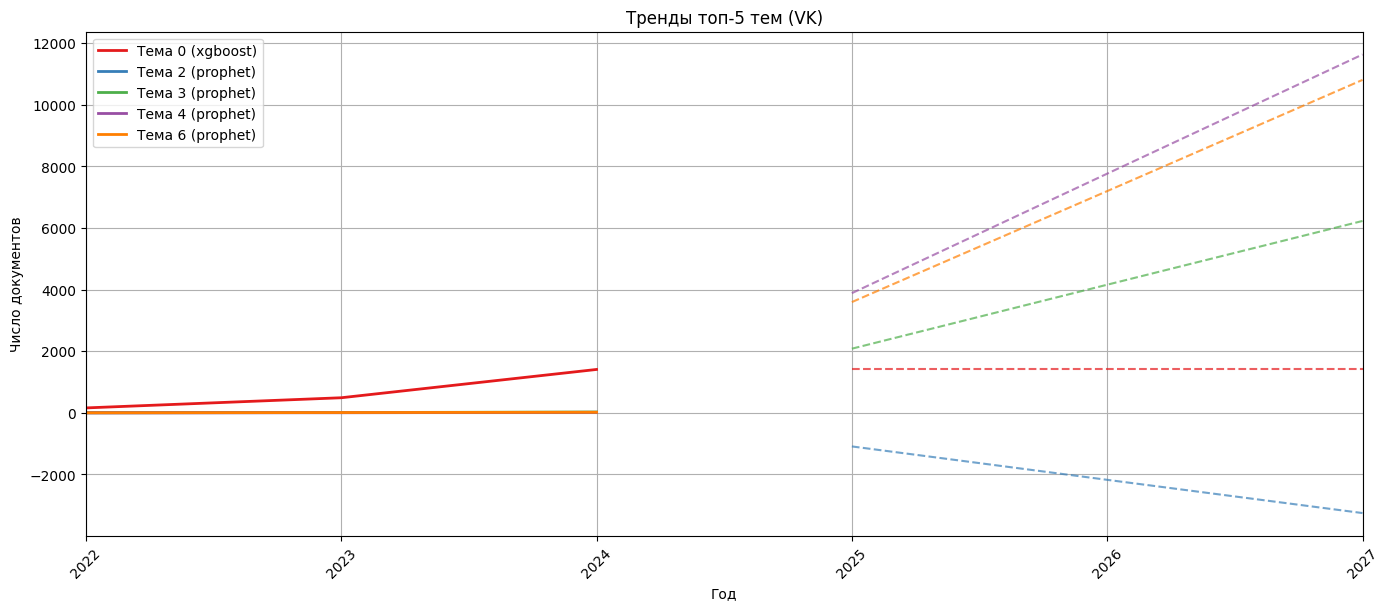


Анализ: GNews
Исключен неполный год: 2025


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: Conver

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.7175e-05
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.6383e-05
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0577e-05
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7282e-05
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.3797e-05
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.9104e-05
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6294e-05
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.3180e-05
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5714e-05
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.8994e-05
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8508e-05
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.6817e-05
Epoch 13/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9298e-05
Epoch 14/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.7227e-05
Epoch 15/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/3yduewt_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/onzkjkrp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70006', 'data', 'file=/tmp/tmpdzlt5y0c/3yduewt_.json', 'init=/tmp/tmpdzlt5y0c/onzkjkrp.json', 'output', 'file=/tmp/tmpdzlt5y0c/prophet_modelj5mejpob/prophet_model-20250617154532.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:45:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:45:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version,

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.8130e-05
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.2852e-05
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.5249e-05
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.2419e-05
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.5592e-05
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.2562e-05 
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.5277e-05
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.2285e-05
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5453e-05
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.2398e-05
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5269e-05
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.2340e-05
Epoch 13/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5401e-05
Epoch 14/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.2301e-05
Epoch 15/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss:

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/7bljl_8f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/elt_n3n9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91441', 'data', 'file=/tmp/tmpdzlt5y0c/7bljl_8f.json', 'init=/tmp/tmpdzlt5y0c/elt_n3n9.json', 'output', 'file=/tmp/tmpdzlt5y0c/prophet_model3locievz/prophet_model-20250617154544.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:45:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:45:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version,

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.7200e-04
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.4181e-04
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.1505e-04
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4052e-04
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.1074e-04
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3824e-04
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0814e-04
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3804e-04
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.0581e-04
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3786e-04
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.0632e-04
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3576e-04
Epoch 13/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0665e-04
Epoch 14/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.3637e-04
Epoch 15/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/ulalqv30.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/v6z_6p38.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70797', 'data', 'file=/tmp/tmpdzlt5y0c/ulalqv30.json', 'init=/tmp/tmpdzlt5y0c/v6z_6p38.json', 'output', 'file=/tmp/tmpdzlt5y0c/prophet_model3bnh4tkh/prophet_model-20250617154552.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:45:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:45:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version,

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4.0045e-04
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.9163e-04
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9096e-04
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8750e-04
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8052e-04
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9110e-04
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7784e-04
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8846e-04
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7919e-04
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8563e-04
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8032e-04
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8581e-04
Epoch 13/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7818e-04
Epoch 14/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.8693e-04
Epoch 15/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/k7f4xv8y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/vc13x3n3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70648', 'data', 'file=/tmp/tmpdzlt5y0c/k7f4xv8y.json', 'init=/tmp/tmpdzlt5y0c/vc13x3n3.json', 'output', 'file=/tmp/tmpdzlt5y0c/prophet_model2pltckfh/prophet_model-20250617154620.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:46:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:46:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version,

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0070   
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0165
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068    
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0161
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068    
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0159
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069    
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0158
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0069    
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0158
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069    
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0158
Epoch 13/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069     
Epoch 14/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0158
Epoch 15/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068    
Epoch 16/20
3/3 ━

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/zxp73byl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/17axn2x5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95011', 'data', 'file=/tmp/tmpdzlt5y0c/zxp73byl.json', 'init=/tmp/tmpdzlt5y0c/17axn2x5.json', 'output', 'file=/tmp/tmpdzlt5y0c/prophet_model0x0ku6uo/prophet_model-20250617154626.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:46:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:46:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version,


Сравнение моделей по метрикам (RMSE и MAPE):


Метод,arima,holt,linear,lstm,prophet,random_forest,xgboost
Тема,,,,,,,
0,9.85,12.36,25.41,32.31,6.50,5.45,0.0
1,6.21,6.58,9.85,12.29,3.27,2.77,0.0
2,2.49,2.71,5.37,6.59,1.50,0.98,0.0
3,1.43,1.72,1.95,2.46,1.11,0.77,0.0
4,2.66,2.64,3.04,3.82,1.75,0.96,0.0


Метод,arima,holt,linear,lstm,prophet,random_forest,xgboost
Тема,,,,,,,
0,126.71,85.14,620.35,53.65,162.37,16.74,0.05
1,66.38,55.31,211.01,92.17,59.11,17.16,0.10
2,54.61,57.32,170.00,76.67,46.31,20.42,0.10
3,85.17,81.12,63.92,100.92,69.77,30.70,0.11
4,125.97,102.72,94.96,79.30,50.22,39.49,0.04



Итоговая таблица лучших моделей по RMSE для каждой темы:


,Тема,Лучшая модель,Лучший RMSE,Лучший MAPE (%)
0,0,xgboost,0.0,0.05
1,1,xgboost,0.0,0.10
2,2,xgboost,0.0,0.10
3,3,xgboost,0.0,0.11
4,4,xgboost,0.0,0.04


График сохранён: /content/drive/MyDrive/TextScope/plots/GNews_topic_trends.png


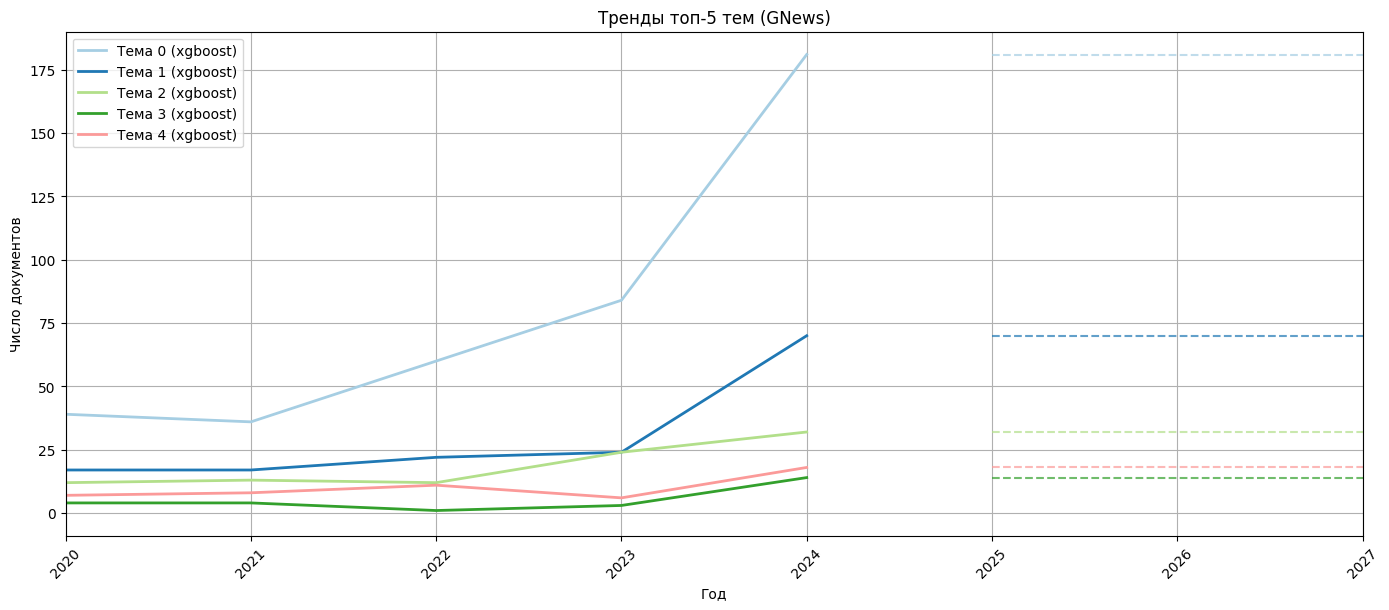


Анализ: CyberLeninka
Исключен неполный год: 2025


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: Conver

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0320   
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0305    
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0290     
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0277    
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0264    
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0253
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0244
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0236
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0230
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0225
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0221
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0218
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0216
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0215
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0214
Epoch 16/20
5/5 ━━━━━━━━━━━━━

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/xzpfw6x8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/mr294cai.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78812', 'data', 'file=/tmp/tmpdzlt5y0c/xzpfw6x8.json', 'init=/tmp/tmpdzlt5y0c/mr294cai.json', 'output', 'file=/tmp/tmpdzlt5y0c/prophet_modelwy2bclgc/prophet_model-20250617154642.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:46:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:46:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version,

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0375   
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0360     
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0346    
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0333    
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0321    
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0310    
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0300
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0291
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0283
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0276
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0270
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0264
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0259
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0255
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0251
Epoch 16/20
5/5 ━━━━━━━━━

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/qfjpeh_z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/y4sy4rrm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25543', 'data', 'file=/tmp/tmpdzlt5y0c/qfjpeh_z.json', 'init=/tmp/tmpdzlt5y0c/y4sy4rrm.json', 'output', 'file=/tmp/tmpdzlt5y0c/prophet_modelesdfj6q0/prophet_model-20250617154654.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:46:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:46:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version,

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0418   
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0398    
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0379    
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0361    
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0344    
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0329
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0316
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0304
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0293
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0284
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0276
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0268
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0262
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0256
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0251
Epoch 16/20
5/5 ━━━━━━━━━━━━━━

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/hq6e1ygf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/0kftryh_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26463', 'data', 'file=/tmp/tmpdzlt5y0c/hq6e1ygf.json', 'init=/tmp/tmpdzlt5y0c/0kftryh_.json', 'output', 'file=/tmp/tmpdzlt5y0c/prophet_modelb9fa1x3k/prophet_model-20250617154706.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:47:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:47:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version,

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0322   
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0309    
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0297    
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0285    
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0274    
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0264    
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0255    
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0247
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0239
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0232
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0225
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0219
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0213
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0208
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0203
Epoch 16/20
5/5 ━━━━━━

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/2mu2ob5g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/q47aqq7a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70179', 'data', 'file=/tmp/tmpdzlt5y0c/2mu2ob5g.json', 'init=/tmp/tmpdzlt5y0c/q47aqq7a.json', 'output', 'file=/tmp/tmpdzlt5y0c/prophet_model7hiuykje/prophet_model-20250617154718.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:47:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:47:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version,

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0413   
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0394    
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0375    
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0357    
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0341    
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0326    
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0313
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0301
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0290
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0280
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0271
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0262
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0254
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0246
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0235
Epoch 16/20
5/5 ━━━━━━━━━━

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/uae48avf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdzlt5y0c/0_uf91c9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2479', 'data', 'file=/tmp/tmpdzlt5y0c/uae48avf.json', 'init=/tmp/tmpdzlt5y0c/0_uf91c9.json', 'output', 'file=/tmp/tmpdzlt5y0c/prophet_model8zrxqw38/prophet_model-20250617154728.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:47:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:47:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, 


Сравнение моделей по метрикам (RMSE и MAPE):


Метод,arima,holt,linear,lstm,prophet,random_forest,xgboost
Тема,,,,,,,
0,10.33,13.26,47.41,45.55,8.12,4.74,0.01
2,10.53,12.35,48.54,52.60,7.18,3.59,0.03
3,7.01,8.37,39.06,39.15,5.01,3.01,0.02
4,10.64,12.80,52.24,51.95,7.48,4.55,0.02
6,9.23,10.80,53.69,50.76,6.46,3.73,0.01


Метод,arima,holt,linear,lstm,prophet,random_forest,xgboost
Тема,,,,,,,
0,66.26,44.54,1505.84,1246.13,105.78,15.68,0.46
2,60.59,53.98,1369.63,1115.47,58.82,15.74,0.79
3,52.76,48.44,1112.03,691.87,63.20,15.38,0.52
4,64.23,41.11,1331.17,932.08,93.49,13.80,0.83
6,40.15,41.03,1482.69,643.46,82.87,12.14,0.44



Итоговая таблица лучших моделей по RMSE для каждой темы:


,Тема,Лучшая модель,Лучший RMSE,Лучший MAPE (%)
0,0,xgboost,0.01,0.46
1,2,xgboost,0.03,0.79
2,3,xgboost,0.02,0.52
3,4,xgboost,0.02,0.83
4,6,xgboost,0.01,0.44


График сохранён: /content/drive/MyDrive/TextScope/plots/CyberLeninka_topic_trends.png


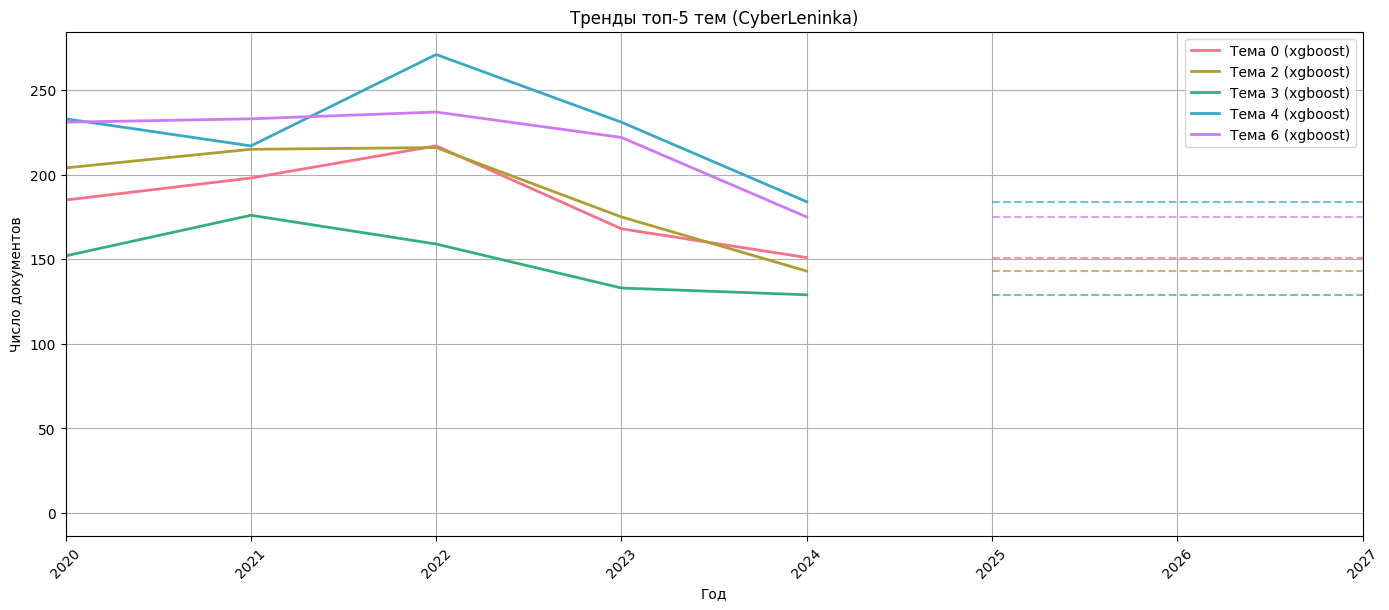

In [7]:
# Пути к данным и моделям
sources = {
    "VK": {
        "data_path": "/content/drive/MyDrive/TextScope/processed_vk_data_topics.csv",
        "model_path": "/content/drive/MyDrive/TextScope/processed_vk_data_topics_bertopic_model"
    },
    "GNews": {
        "data_path": "/content/drive/MyDrive/TextScope/processed_gnews_data_topics.csv",
        "model_path": "/content/drive/MyDrive/TextScope/processed_gnews_data_topics_bertopic_model"
    },
    "CyberLeninka": {
        "data_path": "/content/drive/MyDrive/TextScope/processed_cyberleninka_data_keywords_topics.csv",
        "model_path": None  # LDA — нет BERTopic модели
    }
}

plots_dir = "/content/drive/MyDrive/TextScope/plots"
os.makedirs(plots_dir, exist_ok=True)

for label, paths in sources.items():
    path = paths['data_path']
    model_path = paths['model_path']

    if not os.path.exists(path):
        print(f"Файл не найден: {path} — пропускаем.")
        continue

    print(f"\nАнализ: {label}")
    df = pd.read_csv(path)

    # Определение названия колонки с датой
    date_col = 'date' if 'date' in df.columns else 'published_at' if 'published_at' in df.columns else None
    if date_col is None:
        print(f"Нет колонки с датой в {label} — пропуск.")
        continue

    df_prepared = analyze_and_predict_top_topics(
        df,
        date_column=date_col,
        topic_column='topic',
        label=label,
        model_path=model_path,
        exclude_last_year=True
    )

    plot_topic_trends(
        df_prepared,
        topic_column='topic',
        years_ahead=3,
        label=label,
        save_dir=plots_dir
    )